## Active Learning

The class provides tools for active learning of regression models using expected model change (EMC) and query by committee (QBC) methods and approaches for distribution shift alleviations.

The central idea behind any active learning approach is to achieve lower prediction errors (higher accuracy) in machine learning models by choosing less but more informative data points.

The implementation of this algorithm follows an interactive approach. In other words, we often ask you to provide labels for the selected data points.

Here is a list of main methods to carry out an active learning approach:

- initialize
- deposit
- ignore
- search
- visualize

In [1]:
import warnings
warnings.filterwarnings('ignore')

from chemml.optimization import ActiveLearning
from chemml.datasets import load_organic_density
import numpy as np
import pandas as pd

For this tutorial, we load a sample data from ChemML datasets.

In [2]:
smi, density, features = load_organic_density()
print('labels  : density,    ', type(density), ', shape:', density.shape)
print('features: molecular descriptors,', type(features), ', shape:', features.shape)

labels  : density,     <class 'pandas.core.frame.DataFrame'> , shape: (500, 1)
features: molecular descriptors, <class 'pandas.core.frame.DataFrame'> , shape: (500, 200)


### Keras model example

The current version of the EMC approach only work with Keras deep learning models. You should create a function that returns a Keras model. You can also set the optimizer parameters and compile the model inside the function. Here is a toy example for the Keras model:

In [3]:
from keras.layers import Input, Dense, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform
from keras import regularizers
from keras import losses
from keras import backend as K

In [4]:
def model_creator(nneurons=features.shape[1], activation=['relu','tanh'], lr = 0.001):
    # branch 1
    b1_in = Input(shape=(nneurons, ), name='inp1')
    l1 = Dense(12, name='l1', activation=activation[0])(b1_in)
    b1_l1 = Dense(6, name='b1_l1', activation=activation[0])(l1)
    b1_l2 = Dense(3, name='b1_l2', activation=activation[0])(b1_l1)
    # branch 2
    b2_l1 = Dense(16, name='b2_l1', activation=activation[1])(l1)
    b2_l2 = Dense(8, name='b2_l2', activation=activation[1])(b2_l1)
    # merge branches
    merged = Concatenate(name='merged')([b1_l2, b2_l2])
    # linear output
    out = Dense(1, name='outp', activation='linear')(merged)
    ###
    model = Model(inputs = b1_in, outputs = out)
    adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
    model.compile(optimizer = adam,
                  loss = 'mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

In [5]:
m = model_creator()
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inp1 (InputLayer)   │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1 (Dense)          │ (None, 12)        │      2,412 │ inp1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_l1 (Dense)       │ (None, 6)         │         78 │ l1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_l1 (Dense)       │ (None, 16)        │        208 │ l1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b1_l2 (Dense)       │ (None, 3)         │         21 │ b1_l1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b2_l2 (Dense)       │ (None, 8)         │        136 │ b2_l1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged              │ (None, 11)        │          0 │ b1_l2[0][0],      │
│ (Concatenate)       │                   │            │ b2_l2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outp (Dense)        │ (None, 1)         │         12 │ merged[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,867 (11.20 KB)

 Trainable params: 2,867 (11.20 KB)

 Non-trainable params: 0 (0.00 B)

To view workflow, you need to install `pydot`. For example with `pip install pydot`. Then run the following code

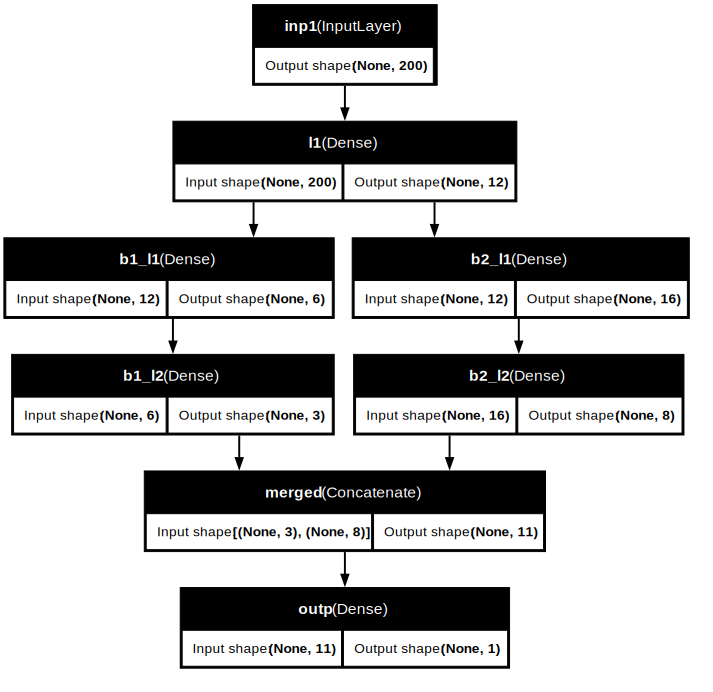

In [6]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(m, show_shapes= True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))

### Initialize active learning: EMC

You first need to instantiate the active learning class using the model_creator function and the pool of candidates (i.e., U) represented by your choice of features.

In [7]:
al = ActiveLearning(
           model_creator = model_creator,
           U = features,
           target_layer = ['b1_l2', 'b2_l2'], # we could also enter 'merged' layer because it only does the concatenation
           train_size = 50,  # 50 initial training data will be selected randomly
           test_size = 50,  # 50 independent test data will be selected randomly for the entire search
           batch_size = [20,0,0] # at each round of AL, labels for 20 candidates will be queried using EMC method
           )

you first need to initialize the method to get the indices for the training and test data:

In [8]:
tr_ind, te_ind = al.initialize()

The array of queried points are always available via the queries attribute

In [9]:
al.queries

[['initial training set',
  array([445, 171, 373, 342, 372,  99, 331, 195, 199, 130, 140, 201, 451,
         300, 294, 108, 369,  79, 328, 398, 485, 426,  43, 391,  71, 124,
         495, 276, 316, 383, 498, 225, 440, 148, 122,  35, 178, 456, 253,
         216, 131, 374, 419, 357, 211, 389, 458, 324, 415, 355])],
 ['test set',
  array([ 51,  48, 223, 254, 118, 258, 399, 231, 462, 292, 438, 266,  97,
          28, 119, 103, 464, 242, 101, 250, 321, 468, 144, 123, 206, 227,
         410, 403, 326, 229, 363,  39, 407, 416,  38, 430, 441, 465,  78,
         346,  13, 281, 256,  85, 273, 151, 404, 161, 370, 431])]]

Once you acquire labels for the queried data (e.g., by experiment or simulation) give them to the al object using deposit method. This can be done partially or all at once.

In [10]:
al.deposit(tr_ind, density.values.reshape(-1,1)[tr_ind])
al.deposit(te_ind, density.values.reshape(-1,1)[te_ind])

we stored 50 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.
we stored 50 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.


True

In [11]:
print (al.X_train.shape, al.Y_train.shape)
print (al.X_test.shape, al.Y_test.shape)

(50, 200) (50, 1)
(50, 200) (50, 1)


In [12]:
al.queries

[]

You can not initialize the method or deposit any more data once you empty the list of queries by providing requested data.

In [13]:
#al.initialize()
# the above code raises following error message:
# ValueError: The class has been already initialized and it can not be initialized again!

### Start the active search

In [14]:
q = al.search(n_evaluation=1, epochs=10, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [15]:
q

array([ 40, 138, 153, 155, 160, 173, 214, 248, 283, 310, 343, 356, 385,
       393, 402, 408, 427, 433, 477, 482])

In [16]:
al.queries

[['batch #1',
  array([ 40, 138, 153, 155, 160, 173, 214, 248, 283, 310, 343, 356, 385,
         393, 402, 408, 427, 433, 477, 482])]]

In [17]:
al.results

,num_query,num_training,num_test,mae,mae_std,rmse,rmse_std,r2,r2_std
0,0,50,50,52.235659,0.0,63.67875,0.0,0.340604,0.0


now you need to deposit the labels for the first batch of queried data using EMC approach.

In [18]:
al.deposit(q, density.values.reshape(-1,1)[q])

we stored 20 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.


True

In [19]:
q = al.search(epochs=10, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [20]:
q

array([  3,   8,  15,  16,  47,  50,  75,  91, 112, 165, 175, 197, 217,
       224, 264, 278, 338, 353, 423, 483])

Here is a data frame of the results in terms of mean absolute error, root mean square error, and r-squared

In [21]:
al.results

,num_query,num_training,num_test,mae,mae_std,rmse,rmse_std,r2,r2_std
0,0,50,50,52.235659,0.000000,63.678750,0.000000,0.340604,0.000000
1,1,70,50,47.562849,9.865081,58.327748,11.807654,0.424096,0.212494


### Get a baseline: random sampling

You can get a baseline learning curve by running a `random_search`. This method starts from the initial sets of training and test data, and adds the same number of data as batch_size every round.

In [22]:
al.random_search(density.values.reshape(-1,1), n_evaluation=2, epochs=10, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/stepWARNING:tensorflow:6 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F5E2936CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


True

The results of random sampling is also accessible using `random_results` attribute:

In [23]:
al.random_results

,num_query,num_training,num_test,mae,mae_std,rmse,rmse_std,r2,r2_std
0,0,50,50,45.216390,7.688320,57.787159,9.361563,0.442724,0.175941
1,1,70,50,39.659886,2.165134,52.483417,4.332977,0.549026,0.073960


### Visualize distributions

We keep track of many metrics to analyze your active learning search. You can store the info during your search or visualize them at each round. The `visualize` method is able to return a dictionary of matplotlib figures for the distribution of features and labels, and the learning curves.

In [24]:
plots = al.visualize(density.values.reshape(-1,1)) # Let's provide all the labels, now that we have all of them

In [25]:
plots

{'dist_pc': (<Figure size 640x480 with 1 Axes>,
  <Figure size 640x480 with 1 Axes>,
  <Figure size 640x480 with 1 Axes>),
 'dist_y': (<Figure size 640x480 with 1 Axes>,
  <Figure size 640x480 with 1 Axes>,
  <Figure size 640x480 with 1 Axes>),
 'learning_curve': <Figure size 640x480 with 1 Axes>}

The distribution of the first principal component:

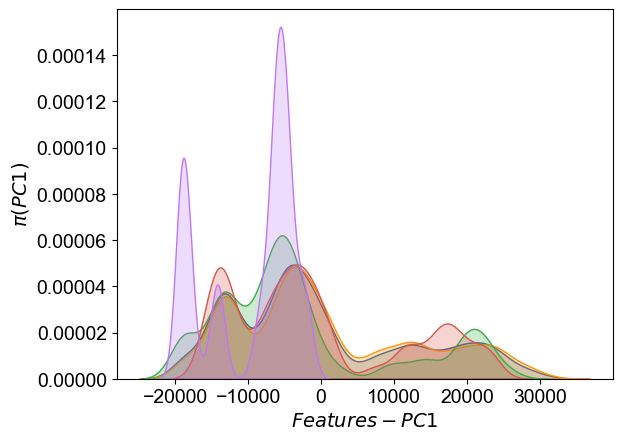

In [26]:
%matplotlib inline
plots['dist_pc'][0]

The distribution of the labels:

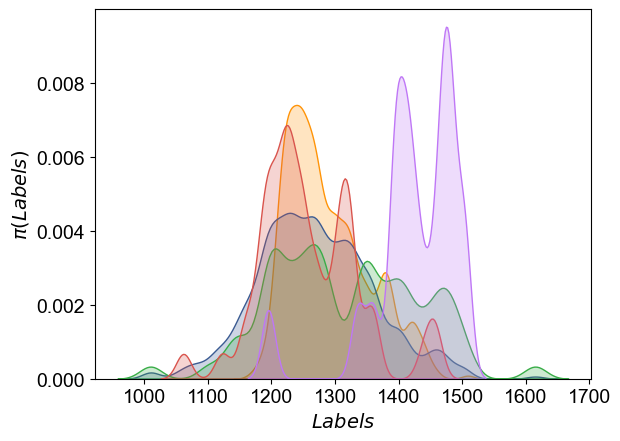

In [27]:
plots['dist_y'][0]

The learning curves:

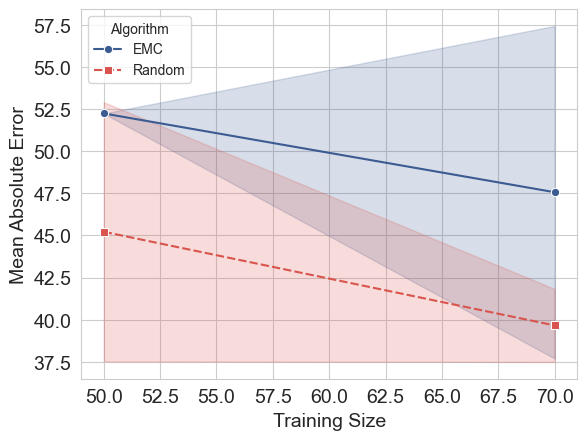

In [28]:
plots['learning_curve']

### Search in a loop

This is how we use this module in a loop:

In [30]:
import os
warnings.filterwarnings('ignore')

out_dir = 'al_toy_example' # the arbitrary path to the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# all data sets must be 2-dimensional
y = density.values.reshape(-1,1)

al = ActiveLearning(
           model_creator = model_creator,
           U = features,
           target_layer = ['b1_l2', 'b2_l2'], # we could also enter 'merged' layer because it only does the concatenation
           train_size = 100,  # 100 initial training data will be selected randomly
           test_size = 50,  # 50 independent test data will be selected randomly for the entire search
           batch_size = [50,0,0] # at each round of AL, labels for 20 candidates will be queried using EMC method
           )

tr_ind, te_ind = al.initialize()


al.deposit(tr_ind, y[tr_ind])
al.deposit(te_ind, y[te_ind])


while al.query_number < 5:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, verbose=0, mode='auto')
    tr_ind = al.search(n_evaluation=3, ensemble='kfold', n_ensemble=3, normalize_input=True, normalize_internal=False,
    batch_size=32, epochs=5, verbose=0)#, callbacks=[early_stopping],validation_split=0.1)

    al.results.to_csv(out_dir+'/emc.csv',index=False)

    pd.DataFrame(al.train_indices).to_csv(out_dir+'/train_indices.csv',index=False)
    pd.DataFrame(al.test_indices).to_csv(out_dir+'/test_indices.csv',index=False)

    al.deposit(tr_ind, y[tr_ind])

    # you can run random search later but, I need it to be in my learning curve
    al.random_search(y, n_evaluation=3, random_state=13, batch_size=32, epochs=5, verbose=0)#, callbacks=[early_stopping],validation_split=0.05)

    al.random_results.to_csv(out_dir+'/random.csv',index=False)

    plots = al.visualize(y)
    if not os.path.exists(out_dir+"/plots"):
        os.makedirs(out_dir+"/plots")

    plots['dist_pc'][0].savefig(out_dir+"/plots/dist_pc_0_%i.png"%al.query_number)# , close = True, verbose = True)
    plots['dist_y'][0].savefig(out_dir+"/plots/dist_y_0_%i.png"%al.query_number)# , close = True, verbose = True)
    plots['learning_curve'].savefig(out_dir+"/plots/lcurve_%i.png"%al.query_number)#, close = True, verbose = True)


we stored 100 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.
we stored 50 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
we stored 50 of passed indices. A list of them is in the 'last_deposited_indices_' attribute.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━

In [31]:
al.results

,num_query,num_training,num_test,mae,mae_std,rmse,rmse_std,r2,r2_std
0,0,100,50,42.286460,7.604904,55.063699,10.609402,0.488650,0.202795
1,1,150,50,42.174142,4.981477,54.359089,6.561031,0.512491,0.120509
2,2,200,50,34.254397,2.419361,42.046462,3.157107,0.710894,0.044060
3,3,250,50,33.343583,6.578607,40.832199,8.060312,0.718315,0.099726
4,4,300,50,29.987748,1.177923,37.520587,2.378018,0.770154,0.029591


In [32]:
al.random_results

,num_query,num_training,num_test,mae,mae_std,rmse,rmse_std,r2,r2_std
0,0,100,50,44.773474,6.886911,57.323165,7.641993,0.456164,0.145890
1,1,150,50,37.735247,5.263009,46.901441,6.405237,0.635620,0.101938
2,2,200,50,36.378079,4.676701,45.963672,5.200160,0.652055,0.080589
3,3,250,50,35.486844,9.098630,44.663603,12.942464,0.648373,0.207024
4,4,300,50,23.700192,1.753282,30.448780,1.795343,0.848712,0.017457


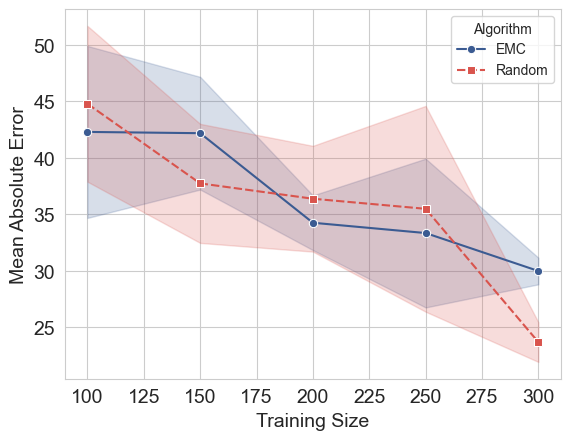

In [33]:
plots = al.visualize(y)
plots['learning_curve']

### Create a video

If you store all the plots at each round you will be able to create a video similar to these ones:

In [34]:
from IPython.display import HTML
from base64 import b64encode
with open("images/dist_y.mov", "rb") as f:
    video = f.read()
video_encoded = b64encode(video).decode('ascii')
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)

In [35]:
from IPython.display import HTML
from base64 import b64encode
with open("images/lcurve.mov", "rb") as f:
    video = f.read()
video_encoded = b64encode(video).decode('ascii')
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)